In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 3) array of binary states into (N, M) indices in [0..7].

    Mapping:
      - [a, b, c] are binary bits (0 or 1), forming a 3-bit number: a*4 + b*2 + c
      - NaN-safe: if any of the 3 elements is NaN, output is NaN

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 3).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M) with values in [0..7] or NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 3).")

    nan_mask = np.isnan(all_state_array).any(axis=-1)
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    valid_mask = ~nan_mask
    valid_data = all_state_array[valid_mask]  # shape (?, 3)

    a = valid_data[:, 0]
    b = valid_data[:, 1]
    c = valid_data[:, 2]

    result = (a * 4 + b * 2 + c).astype(float)
    indexed_states[valid_mask] = result

    return indexed_states


In [5]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs):
    """
    Calculates the average conformational state population and standard error over time across multiple trajectories.

    Parameters
    ----------
    trajs : np.ndarray
        A 2D array of shape (n_traj, timesteps), where each value is an integer in [0, 7]
        representing the conformational state at that time.

    Returns
    -------
    conform_all_population : np.ndarray
        Array of shape (8, timesteps) — average cumulative population per conformation.

    conform_all_population_err : np.ndarray
        Array of same shape — standard error per conformation.
    """
    trajs = np.asarray(trajs)
    n_traj, n_time = trajs.shape
    conform_num = 8  # 8 possible conformational states

    conform_all_population = np.zeros((conform_num, n_time), dtype=float)
    conform_all_population_err = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in tqdm(range(conform_num), desc="Calculating"):
        # Binary mask for the current conformation across all trajectories
        match_mask = (trajs == conform_state).astype(int)  # shape: (n_traj, n_time)
        
        # Cumulative counts per trajectory
        cumulative_counts = np.cumsum(match_mask, axis=1)  # shape: (n_traj, n_time)
        
        sample_counts = np.arange(1, n_time + 1)[None, :]   # shape: (1, n_time)
        proportions = cumulative_counts / sample_counts     # shape: (n_traj, n_time)

        # Mean and standard error across trajectories
        mean_p = np.nanmean(proportions, axis=0)
        se_p = np.nanstd(proportions, axis=0, ddof=1) / np.sqrt(n_traj)

        conform_all_population[conform_state] = mean_p
        conform_all_population_err[conform_state] = se_p

    print('Conform population shape:', conform_all_population.shape)
    print('Conform population error shape:', conform_all_population_err.shape)

    return conform_all_population, conform_all_population_err


## The Trans Population overtime Plot

In [7]:
omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array

In [8]:
print(len(all_omega)) 

all_omega[0].shape
all_omega[0]

742


array([[-173.65106  ,    8.187268 ,  158.7122   ],
       [ 149.942    ,   -5.472654 , -179.34113  ],
       [ 162.98587  ,    2.9294653, -170.57141  ],
       ...,
       [ -25.63846  ,    6.4290886, -142.46432  ],
       [  -1.3674331,   47.98817  , -169.6922   ],
       [ -16.094692 ,   27.522018 ,  177.88043  ]], dtype=float32)

In [11]:
## Create a (ntraj, ntimestep) with 3 binary cistrans convert to conform state [0...7]

ntraj = len(all_omega)
all_cistrans = []
for i in range(ntraj):
    all_cistrans.append(omega2cistrans(all_omega[i]))

all_cistrans

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

print('traj.shape', traj.shape)


all_comform = state_to_index_vectorized(traj)

all_comform = np.array(all_comform)
print('all_comform.shape', all_comform.shape)
all_comform[1]


maxlength 196095
traj.shape (742, 196095, 3)
all_comform.shape (742, 196095)


array([ 1.,  1.,  1., ..., nan, nan, nan])

In [12]:
conform_thermo_all_population = []
conform_thermo_all_population_err = []

conform_all_population, conform_all_population_err = calculate_conform_p(all_comform)

conform_thermo_all_population.append(conform_all_population)
conform_thermo_all_population_err.append(conform_all_population_err)

conform_thermo_all_population = np.array(conform_thermo_all_population)
conform_thermo_all_population_err = np.array(conform_thermo_all_population_err)

print('trans_all_population.shape', conform_thermo_all_population.shape)
print('conform_thermo_all_population_err.shape', conform_thermo_all_population_err.shape)

Calculating: 100%|██████████| 8/8 [01:17<00:00,  9.72s/it]


Conform population shape: (8, 196095)
Conform population error shape: (8, 196095)
trans_all_population.shape (1, 8, 196095)
conform_thermo_all_population_err.shape (1, 8, 196095)


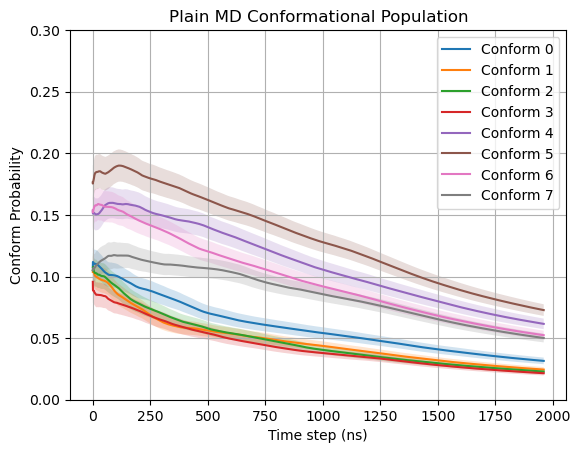

In [17]:
conform_num = 8
thermo_state = 1
time_in_ns = 0.01


for conform in range(conform_num):  # Loop over 8 conformational states
    y = conform_thermo_all_population[0, conform, :]
    yerr = conform_thermo_all_population_err[0, conform, :]
    x = np.arange(len(y))  # or use actual time values

    plt.plot(x * time_in_ns, y, label=f'Conform {conform}')
    plt.fill_between(x * time_in_ns, y - yerr, y + yerr, alpha=0.2)

plt.title(f'Plain MD Conformational Population')
plt.xlabel('Time step (ns)')
plt.ylabel('Conform Probability')
plt.ylim(0, 0.3)
plt.grid(True)
plt.legend(loc="best")
#plt.tight_layout()
plt.show()


## Error Over Times

In [21]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conform.csv")
#print(df_stationary_p)


# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_array.shape

(1, 8)

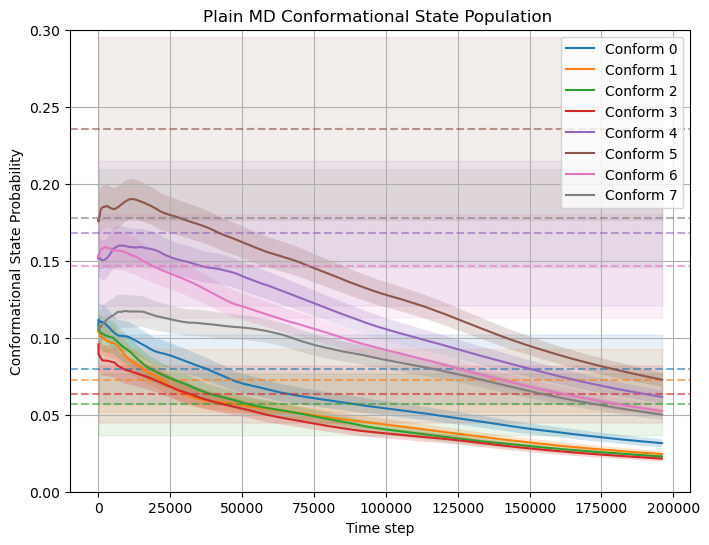

In [26]:
thermo_num = 1
conform_num = 8

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x, y, label=f'Conform {conform}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{conform}', alpha=0.6)
        plt.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{conform}', alpha=0.1)

    plt.title(f'Plain MD Conformational State Population ')
    plt.xlabel('Time step')
    plt.ylabel('Conformational State Probability')
    plt.grid(True)
    plt.legend(loc='best')
    #plt.tight_layout()
    plt.ylim(0, 0.3)
    plt.show()


### Plot the ERROR

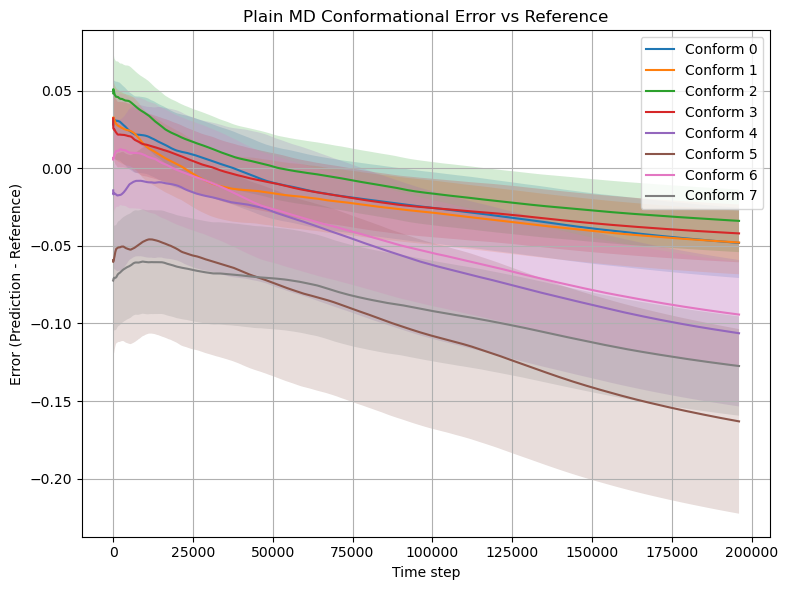

In [27]:
thermo_num = 1
conform_num = 8


for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = conform_thermo_all_population[thermo, conform, :]
        yerr = conform_thermo_all_population_err[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        # Reference horizontal line
        ref_y = trans_refer_array[thermo, conform]
        ref_yerr = trans_refer_err_array[thermo, conform]

        error = y - ref_y
        error_err = np.sqrt(
            yerr ** 2 +
            ref_yerr ** 2
        )

        plt.plot(x, error, label=f'Conform {conform}')
        plt.fill_between(x, error - error_err, error + error_err, alpha=0.2)

    plt.title(f'Plain MD Conformational Error vs Reference')
    plt.xlabel('Time step')
    plt.ylabel('Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    #plt.ylim(-0.03, 0.03)
    plt.tight_layout()
    plt.show()
